In [15]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [5]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [6]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [7]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [8]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [9]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

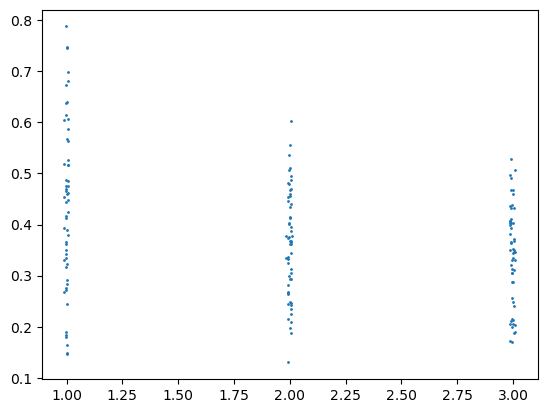

In [10]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

In [11]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [12]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(166, 3)


In [13]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [17]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_11g_04.pt"))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [18]:
net.train()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=166, out_features=166, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=166, out_features=166, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=166, out_features=166, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=166, out_features=166, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=166, out_features=166, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=166, out_features=166, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=166, out_features=5, bias=True)
  )
)

In [19]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.96it/s]


Loss: 408.32700190972537
Average Loss: 0.05587397398874184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.51it/s]


Loss: 408.3090371398721
Average Loss: 0.055871515755319116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.82it/s]


Loss: 408.5226200937759
Average Loss: 0.05590074166581498
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.96it/s]


Loss: 408.38513665343635
Average Loss: 0.0558819289345151
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.05it/s]


Loss: 408.28524237219244
Average Loss: 0.05586825976630986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.87it/s]


Loss: 408.16077916068025
Average Loss: 0.05585122867551728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.62it/s]


Loss: 408.2698318052571
Average Loss: 0.05586615104067558
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.77it/s]


Loss: 408.3387029999867
Average Loss: 0.05587557512315089
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.81it/s]


Loss: 408.15200159233063
Average Loss: 0.05585002758515745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.69it/s]


Loss: 408.2630420560017
Average Loss: 0.05586522195621261
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▉                                                                                                                                                           | 137/7308 [00:02<00:49, 144.94it/s]

X_batch: 
torch.Size([128, 166])
tensor([[0.2926, 0.4388, 0.3789,  ..., 0.3750, 0.1232, 0.1618],
        [0.6790, 0.2033, 0.2306,  ..., 0.3761, 0.1625, 0.3786],
        [0.1676, 0.0912, 0.1069,  ..., 0.1503, 0.0958, 0.0713],
        ...,
        [0.3845, 0.2856, 0.2548,  ..., 0.4657, 0.1793, 0.2889],
        [0.5465, 0.2784, 0.2141,  ..., 0.4846, 0.1025, 0.3471],
        [0.3947, 0.4545, 0.1969,  ..., 0.5131, 0.1532, 0.3006]])
X_pred: 
torch.Size([128, 166])
tensor([[0.3167, 0.3963, 0.3951,  ..., 0.4166, 0.1640, 0.1355],
        [0.5959, 0.3292, 0.1619,  ..., 0.4651, 0.2561, 0.3110],
        [0.1745, 0.1088, 0.1006,  ..., 0.1751, 0.0771, 0.1126],
        ...,
        [0.4812, 0.2835, 0.2105,  ..., 0.4781, 0.1935, 0.3355],
        [0.4670, 0.3223, 0.0989,  ..., 0.4430, 0.1312, 0.2990],
        [0.4185, 0.3645, 0.2166,  ..., 0.4907, 0.1234, 0.2927]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.41it/s]


Loss: 408.1345545721706
Average Loss: 0.05584764019870971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.54it/s]


Loss: 408.21208208287135
Average Loss: 0.05585824877981272
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.63it/s]


Loss: 408.1253252378665
Average Loss: 0.05584637729034845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.58it/s]


Loss: 408.0803999225609
Average Loss: 0.05584022987446099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.86it/s]


Loss: 408.12235082755797
Average Loss: 0.05584597028291707
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.38it/s]


Loss: 408.1645621100906
Average Loss: 0.05585174632048312
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.76it/s]


Loss: 408.1224477386568
Average Loss: 0.0558459835438775
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.55it/s]


Loss: 408.01303815678693
Average Loss: 0.055831012336725085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.44it/s]


Loss: 408.016675533494
Average Loss: 0.05583151006205446
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.09it/s]


Loss: 407.92471069144085
Average Loss: 0.055818925929315935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.19it/s]


Loss: 407.98634384712204
Average Loss: 0.05582735958499207
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.04it/s]


Loss: 408.06976598338224
Average Loss: 0.0558387747651043
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.37it/s]


Loss: 407.93109987676144
Average Loss: 0.05581980020207464
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.99it/s]


Loss: 407.92996741179377
Average Loss: 0.05581964523970905
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.62it/s]


Loss: 407.9659505796153
Average Loss: 0.05582456904482968
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.03it/s]


Loss: 407.8261315142736
Average Loss: 0.055805436715144166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.71it/s]


Loss: 408.20096583710983
Average Loss: 0.055856727673386675
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.50it/s]


Loss: 407.7715088429395
Average Loss: 0.05579796234851389
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.28it/s]


Loss: 407.8322094012983
Average Loss: 0.05580626839098225
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.75it/s]


Loss: 407.8278385263402
Average Loss: 0.05580567029643407
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.31it/s]


Loss: 407.9018502398394
Average Loss: 0.05581579778870271
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.64it/s]


Loss: 407.89342136355117
Average Loss: 0.05581464441208965
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.15it/s]


Loss: 407.83959401771426
Average Loss: 0.05580727887489248
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.25it/s]


Loss: 407.779529504478
Average Loss: 0.05579905986651313
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.09it/s]


Loss: 407.857330071507
Average Loss: 0.05580970581164573
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.66it/s]


Loss: 407.8118038889952
Average Loss: 0.0558034761752867
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.68it/s]


Loss: 407.86861665337346
Average Loss: 0.05581125022624158
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.31it/s]

Loss: 407.941672263667
Average Loss: 0.05582124688884332
Done, best loss: 407.7715088429395
Done


<All keys matched successfully>

In [20]:
torch.save(final_model, 'model_100206_11g_04_update1.pt')